# Achieving Generalization

지금까지 계속 적합성을 측정하고 검토만하였다. 이제는 실제 테스트를 통해 가장 적합한 비용 측정 또는 교차 검증을 사용해 모델을 테스트 해볼 것이다. 또한 지금 까지 우리가 한것을 점검해보자!  
* 검증/테스트 집합에 가장 적절한 비용 측정 또는 교차 검증을 사용해 모델을 테스트하는 방법
* 통계적 테스트 및 실험을 기반으로 최적의 특성을 선택하는 방법
* 비용 함수를 조정해 모델을 좀더 경제적으로 만드는 방법
* 안정적인 선택 즉, 거의 자동화된 변수 선택 방법

## testing and cross-validation

### Train-test split

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston() 
dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
dataset['target'] = boston.target
observations = len(dataset)
variables = dataset.columns[:-1]
X = dataset.iloc[:,:-1]
y = dataset['target'].values

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
# 파라미터에 표시된 테스트를 위해 지정된 할당량에 따라 데이터를 분리하다.

print ("Train dataset sample size: %i" % len(X_train))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 354
Test dataset sample size: 152


```
from sklearn.model_selection import train_test_split
train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)
```  
(1) Parameter

arrays : 분할시킬 데이터를 입력 (Python list, Numpy array, Pandas dataframe 등..)

test_size : 테스트 데이터셋의 비율(float)이나 갯수(int) (default = 0.25)

train_size : 학습 데이터셋의 비율(float)이나 갯수(int) (default = test_size의 나머지)

random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값 (int나 RandomState로 입력)

shuffle : 셔플여부설정 (default = True)

stratify : 지정한 Data의 비율을 유지한다. 예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때, stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.

​

(2) Return

X_train, X_test, Y_train, Y_test : arrays에 데이터와 레이블을 둘 다 넣었을 경우의 반환이며, 데이터와 레이블의 순서쌍은 유지된다.

X_train, X_test : arrays에 레이블 없이 데이터만 넣었을 경우의 반환


In [3]:
X_train, X_out_sample, y_train, y_out_sample = train_test_split(X, y, test_size=0.40, random_state=101)
X_validation, X_test, y_validation, y_test = train_test_split(X_out_sample, y_out_sample, test_size=0.50, random_state=101)
print ("Train dataset sample size: %i" % len(X_train))
print ("Validation dataset sample size: %i" % len(X_validation))
print ("Test dataset sample size: %i" % len(X_test))
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

Train dataset sample size: 303
Validation dataset sample size: 101
Test dataset sample size: 102
(303, 13)
(101, 13)
(102, 13)


### Cross validation

train 데이터를 통해 모델을 만들어 test set을 통해 모델 성능을 확인하는데 이렇게 계속 지속되면 모델은 test set에만 적합한 모델이 되어 overfitting이 된다. 이를 해결하기 위해 test set을 가변 하여 모델을 검증하는 Cross validation 방법을 사용한다.

In [4]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

def RMSE(y_true, y_pred):
    return np.sum((y_true -y_pred)**2)

lm = LinearRegression()
# k_fold 교차 검증
cv_iterator = KFold(n_splits=10, shuffle=True, random_state=101)

edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)

stratified_cv_iterator = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)

second_order=PolynomialFeatures(degree=2, interaction_only=False)
third_order=PolynomialFeatures(degree=3, interaction_only=True)

over_param_X = second_order.fit_transform(X)
extra_over_param_X = third_order.fit_transform(X)
cv_score = cross_val_score(lm, over_param_X, y, cv=cv_iterator, scoring='neg_mean_squared_error', n_jobs=1) # n_jobs 병렬 계산을 활용한 결과 계산에 포함되는 스레드 수를 설정한다. -1로 설정되면 사용가능한 모든 스레드가 자동적으로 사용 돼 컴퓨터의 계산속도를 최대로 빠르게 한다. 이책에서는 항상 1로 설정

`KFold(n_splits = n, shuffle=boolean, random_state=)`  
n_splits : int, 기본값 = 5
접기 수. 2 이상이어야합니다.

shuffle bool, 기본값 = False
배치로 분할하기 전에 데이터를 섞을 지 여부입니다. 각 분할 내의 샘플은 섞이지 않습니다.

random_state int 또는 RandomState 인스턴스, 기본값 = None
때 shuffleTrue 인, random_state각 배의 임의성을 제어하는 인덱스의 순서에 영향을 미친다. 그렇지 않으면이 매개 변수가 적용되지 않습니다. 여러 함수 호출에서 재현 가능한 출력을 위해 int를 전달합니다.

In [5]:
print (cv_score)

[-11.67358613 -22.84201585  -9.19318785 -19.77458934 -11.68472903
  -9.15302456 -12.97982141 -22.18260706 -35.93064657 -13.75241158]


In [6]:
print ('Cv score: mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score: mean 16.917 std 7.955


In [7]:
cv_score = cross_val_score(lm, over_param_X, y, cv=stratified_cv_iterator.split(X,binning), scoring='neg_mean_squared_error', n_jobs=1)
print ('Cv score: mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score: mean 15.645 std 6.517


### Bootstrapping

훈련 데이터가 작은 것들은 폴드를 하기도 애매하다. 이럴때에 통계적 기법 부트스트래핑을 사용해 기본 분포를 여러 번 복제해 시도함으로 훈련 및 테스트 검증 시퀸스를 반복할 수 있다.

In [8]:

import random
def Bootstrap(n, n_iter=3, random_state=None) : 
    if random_state : # random state 가 있으면 그값을 random seed로 준다
        random.seed(random_state)
    for j in range(n_iter) : # n_iter회 반복 n안의 범위에 정수 로 랜덤 값 생성 
        bs = [random.randint(0,n-1) for i in range(n)] # bs 생긴 함수들
        out_bs = list({i for i in range(n)} - set(bs)) # 없는 상수들
        yield bs, out_bs
    
boot = Bootstrap(n=10, n_iter=5, random_state=101)
for train_idx, validation_idx in boot : 
    print(train_idx, validation_idx)

[9, 3, 8, 5, 7, 0, 8, 3, 9, 3] [1, 2, 4, 6]
[4, 7, 3, 5, 7, 1, 4, 3, 2, 1] [0, 8, 6, 9]
[7, 8, 5, 3, 7, 5, 3, 6, 6, 3] [0, 1, 2, 4, 9]
[1, 6, 7, 4, 3, 1, 9, 5, 4, 6] [0, 8, 2]
[6, 3, 6, 1, 6, 6, 0, 7, 3, 8] [9, 2, 4, 5]


In [9]:

import numpy as np
boot = Bootstrap(n=len(X), n_iter=10, random_state=101)
lm = LinearRegression()
bootstrapped_coef = np.zeros((10,13))
for k, (train_idx, validation_idx) in enumerate(boot) : 
    lm.fit(X.iloc[train_idx,:],y[train_idx])
    bootstrapped_coef[k,:] = lm.coef_

In [10]:
print(bootstrapped_coef[:,10])
print(bootstrapped_coef[:,6])

[-1.0403394  -0.93588809 -1.09205904 -1.10308266 -0.99606246 -0.79789273
 -0.89314749 -0.92206747 -1.02555442 -0.78963414]
[-0.01947474  0.00046413 -0.00026774  0.00604679  0.02211687 -0.00089469
  0.01919428  0.02155958  0.01222277 -0.027093  ]


## Greedy selection of features

### Controlling for over-parameterization

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.30, random_state=3)
lm=LinearRegression()
lm.fit(X_train, y_train)
print('Train (cases, features) = %s' %str(X_train.shape))
print('Test (cases, features) = %s' %str(X_test.shape))
print('In-Sample mean squared error %0.3f' 
      %mean_squared_error(y_train, lm.predict(X_train)))
print('Out-Sample mean squared error %0.3f' 
      %mean_squared_error(y_test, lm.predict(X_test)))

Train (cases, features) = (354, 13)
Test (cases, features) = (152, 13)
In-Sample mean squared error 22.420
Out-Sample mean squared error 22.432


In [12]:

from sklearn.preprocessing import PolynomialFeatures
second_order = PolynomialFeatures(degree=2, interaction_only=False)
third_order = PolynomialFeatures(degree=3, interaction_only=True)

2차 다항식 확장 테스트
---

In [13]:
lm.fit(second_order.fit_transform(X_train),y_train)
print('(cases, features) = %s' %str(second_order.fit_transform(X_train).shape))
print('In-Sample mean squared error %0.3f' 
      %mean_squared_error(y_train, lm.predict(second_order.fit_transform(X_train))))
print('Out-Sample mean squared error %0.3f' 
      %mean_squared_error(y_test, lm.predict(second_order.fit_transform(X_test))))

(cases, features) = (354, 105)
In-Sample mean squared error 14.599
Out-Sample mean squared error 29.190


3차 다항식 확장 테스트
---

In [14]:

lm.fit(third_order.fit_transform(X_train), y_train)
print('(cases, features) = %s' %str(third_order.fit_transform(X_train).shape))
print('In-Sample mean squared error %0.3f' 
      %mean_squared_error(y_train, lm.predict(third_order.fit_transform(X_train))))
print('Out-Sample mean squared error %0.3f' 
      %mean_squared_error(y_test, lm.predict(third_order.fit_transform(X_test))))

(cases, features) = (354, 378)
In-Sample mean squared error 0.438
Out-Sample mean squared error 85785.203


In-Sample mean, Out-sample mean 차이 실화냐...

### Madelon dataset

노이즈가 많고 공선적인 변수 중에서 최상의 변수들을 선택하기 위해 보스턴 데이터셋과 마델론 데이터 셋을 사용하자  
　  
데이터셋은 5차원 하이퍼큐브의 꼭짓점에 32개의 별개의 점 구름을 배치해 생성한 것이다.

In [15]:
try :
    import urllib.request as urllib2 # URL 처리 모듈
except : 
    import urllib2
import numpy as np

# machine-learningdatabases -> machine-learning-databases
train_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
validation_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.data'
train_response = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'
validation_response = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/madelon_valid.labels'

try :
    Xt = np.loadtxt(urllib2.urlopen(train_data))
    yt = np.loadtxt(urllib2.urlopen(train_response))
    Xv = np.loadtxt(urllib2.urlopen(validation_data))
    yv = np.loadtxt(urllib2.urlopen(validation_response))
except : 
    Xt = np.loadtxt('madelon_train.data')
    yt = np.loadtxt('madelon_train.labels')
    Xv = np.loadtxt('madelon_valid.data')
    yv = np.loadtxt('madelon_valid.labels')

In [16]:
print('Training set : %i observations %i feature' %(Xt.shape))
print('Validation set : %i observations %i feature' %(Xv.shape))

Training set : 2000 observations 500 feature
Validation set : 600 observations 500 feature


In [17]:
from scipy.stats import describe
print(describe(Xt)) #describe() : 평균, 최소, 최대, 분산, 왜도, 첨도에 관한 모든 것을 보여준다.

8.29347552e+02, 4.89803498e+02, 7.40620004e+02, 2.94284636e+02,
       1.06350524e+03, 8.39529565e+02, 1.20857128e+02, 9.72263931e+02,
       1.02343131e+02, 5.32404992e+01, 2.15950175e+03, 1.91672852e+03,
       1.51788182e+02, 8.30572386e+02, 3.79832240e+02, 1.37968512e+02,
       3.40294291e+02, 2.79051036e+01, 5.55491415e+02, 7.40252584e+02,
       1.66463228e+02, 1.64962470e+03, 1.06732604e+03, 1.73941058e+02,
       8.97552776e-01, 9.06351815e+02, 1.33422899e+03, 1.51895347e+02,
       1.09288415e+04, 1.21548034e+03, 9.40024334e+03, 1.43148698e+03,
       1.54892304e+03, 5.48334971e+02, 9.16606283e+02, 1.00258693e+03,
       1.89733946e+03, 7.28826053e+01, 4.65988172e+01, 1.84977458e+03,
       5.27831052e+02, 1.06754137e+03, 4.97942611e+01, 1.61843419e+03,
       1.22849033e+03, 1.53847922e+02, 3.67566391e+02, 2.67460814e+02,
       1.59238543e+03, 2.70602901e+00, 1.27214312e+03, 1.68979634e+03,
       1.02173943e+03, 4.43246547e+02, 1.75737115e+03, 5.95242709e+02,
       2.6458

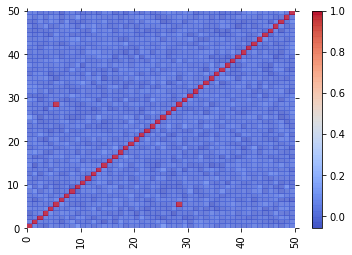

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#matplotlib as mpl

def visualize_correlation_matrix(data, hurdle=0.0) : 
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='both', bottom='off',
                    top='off', left='off', right='off')
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(Xt[:,100:150], hurdle=0.0)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=3000)
logit.fit(Xt,yt)
# 로지스틱회귀에서 임계값이 0.5이상인 경우 관찰치를 양의 값으로 분류한다.
from sklearn.metrics import roc_auc_score
print('Training area under the curve : %0.3f'
      % roc_auc_score(yt, logit.predict_proba(Xt)[:,1]))
print('Validation are under the curve : %0.3f'
      % roc_auc_score(yv, logit.predict_proba(Xv)[:,1]))

Training area under the curve : 0.824
Validation are under the curve : 0.601


## Univariate selection of features

이 데이터셋에서 관련성이 없거나 중복되는 수많은 특성을 처리해야한다. 그 후 모델의 성능을 향상되기를 바래야한다. 샘플 내 값과 샘플 외값 사이의 AUC 점수의 큰차이로 나타난다.

F-값을 통해 그룹 내 분산이 얼마나 되어 있는지 확인해 보자.

In [20]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(Xt,yt)
variable_filter = selector.get_support()

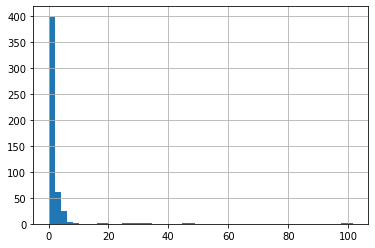

In [21]:
plt.hist(selector.scores_, bins=50, histtype='bar')
plt.grid()
plt.show()

대부분 점수는 0에 가깝고 몇개의 상위 점수가 존재한다. 이제 임계값을 정하고 임계값을 넘는 것을 짤라내자


In [22]:
variable_filter = selector.scores_ > 10 #임계값 10
print('Number of filtered variables : %i' %np.sum(variable_filter))

from sklearn.preprocessing import PolynomialFeatures
interactions = PolynomialFeatures(degree=2, interaction_only=True)
Xs = interactions.fit_transform(Xt[:,variable_filter])
print("Number of variables and interactions ; %i" %Xs.shape[1])

Number of filtered variables : 13
Number of variables and interactions ; 92


이제 핵심 데이터셋을 통해 비선형관계를 다시 검증해보자

In [23]:

logit = LogisticRegression(max_iter=20000)
logit.fit(Xs,yt)
Xvs = interactions.fit_transform(Xv[:,variable_filter])
print('Validation area Under the Curve ' +
      'before recursive selection : %0.3f'
      %roc_auc_score(yv, logit.predict_proba(Xvs)[:,1]))

Validation area Under the Curve before recursive selection : 0.810


### Recursive feature selection

앞선 일변량 선택의 유일한 문제점은 다른 특성과 분리해 별도로 고려해 최상의 특성을 결정하고, 조화롭게 함께 작동하는 방법을 검증하지 않는다는 것이다.

재귀적 제거는 전체 모델로 시작해 각 변수를 차례로 제거함으로써 교차 검증에 의한 제거효과를 평가한다.

In [24]:
from sklearn.feature_selection import RFECV # 우선순위를 고려하여 재귀적 제거 실시
from sklearn.model_selection import KFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.30, random_state=1)

lm=LinearRegression()
cv_iterator = KFold(n_splits=10,
                    shuffle=True,
                    random_state=101)
recursive_selector = RFECV(estimator=lm, step=1, cv=cv_iterator,
                           scoring='neg_mean_squared_error') # estimator
recursive_selector.fit(second_order.fit_transform(X_train),y_train)

print('Initial number of features : %i'
      % second_order.fit_transform(X_train).shape[1])
print('Optimal number of features : %i'
      % recursive_selector.n_features_)

Initial number of features : 105
Optimal number of features : 53


In [25]:
essential_X_train = recursive_selector.transform(second_order.fit_transform(X_train))
essential_X_test = recursive_selector.transform(second_order.fit_transform(X_test))
lm.fit(essential_X_train,y_train)
print('cases = %i features = %i' %essential_X_test.shape)
print('In-Sample mean squared error %0.3f'  # 인풋에 따른 아웃풋 평균
      %mean_squared_error(y_train, lm.predict(essential_X_train))) 
print('Out-Sample mean squared error %0.3f'  # 아웃풋 샘플 평균
      %mean_squared_error(y_test, lm.predict(essential_X_test)))

cases = 152 features = 53
In-Sample mean squared error 7.845
Out-Sample mean squared error 11.852


In [26]:
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y,edges)
stratified_cv_iterator = StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=101)
essential_X = recursive_selector.transform(second_order.fit_transform(X))
cv_score = cross_val_score(lm, essential_X, y,
                          cv=stratified_cv_iterator.split(X,binning),
                          scoring = 'neg_mean_squared_error', n_jobs=1)
print('Cv score : mean %0.3f std %0.3f'
      % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score : mean 10.857 std 4.852


## Regularization

### Ridge

릿지, 랏소, 엘라스틱관련한 웹사이트 https://www.notion.so/Regularization-148578a4b8fb44e4b75a935ae6a36e0b

In [27]:

lm=LinearRegression()
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
ridge.fit(second_order.fit_transform(X),y)
lm.fit(second_order.fit_transform(X),y)

LinearRegression()

In [28]:
print('Average coefficient : Non regularized = %0.3f Ridge = %0.3f'
      % (np.mean(lm.coef_), np.mean(ridge.coef_)))
print('Min coefficient : Non regularized = %0.3f Ridge = %0.3f'
      % (np.min(lm.coef_), np.min(ridge.coef_)))
print('Max coefficient : Non regularized = %0.3f Ridge = %0.3f'
      % (np.max(lm.coef_), np.max(ridge.coef_)))

Average coefficient : Non regularized = 7592022.977 Ridge = -0.027
Min coefficient : Non regularized = -35.002 Ridge = -2.011
Max coefficient : Non regularized = 797162270.345 Ridge = 1.181


### Grid search for optimal parameters

GridSearchCV : 우리가 지정해준 몇가지 잠재적 Parameter들의 후보군들의 조합 중에서 가장 좋은 조합을 찾아준다.

In [29]:
# sklearn.grid_search -> sklearn.model_selection
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(param_grid={'alpha' : np.logspace(-4,2,7)},
                      estimator=ridge, scoring='neg_mean_squared_error',
                      n_jobs=1, refit=True,
                      cv=stratified_cv_iterator.split(X,binning))
search.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search.best_score_))

Best alpha : 0.00100
Best CV mean squared error : 12.121


In [30]:
# search.grid_scores -> search.cv_results
for mean,std,par in zip(search.cv_results_['mean_test_score'],
                         search.cv_results_['std_test_score'],
                         search.cv_results_['params']) : 
    print("mean : {}, std : {}, params : {}".format(mean,std,par))

mean : -12.622903693161106, std : 4.370298562302986, params : {'alpha': 0.0001}
mean : -12.12056280026036, std : 5.5631353899180835, params : {'alpha': 0.001}
mean : -12.285312261504608, std : 6.7008718588302, params : {'alpha': 0.01}
mean : -16.14262623198885, std : 7.895827677862886, params : {'alpha': 0.1}
mean : -22.733719238313448, std : 7.7267611305854995, params : {'alpha': 1.0}
mean : -37.88917137493401, std : 7.704829355071152, params : {'alpha': 10.0}
mean : -66.67200837528631, std : 7.076009998693852, params : {'alpha': 100.0}


In [31]:
search.cv_results

AttributeError: 'GridSearchCV' object has no attribute 'cv_results'

### Random Search

파라미터가 많을 때 하염없는 시간이 필요한 그리드 탐색에서 좀더 나은 솔루션으로 무작위 그리드 검색을 해볼 것이다. 여기서는 100개의 가능한 값에서 샘플링된 10개의 값만 사용한다.

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(estimator=ridge,
                              n_jobs=1, iid=False, refit=True, n_iter=10,
                              param_distributions={'alpha':np.logspace(-4,2,100)},
                              scoring='neg_mean_squared_error',
                              cv=stratified_cv_iterator.split(X,binning))
search_func.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search_func.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search_func.best_score_))

Best alpha : 0.00187
Best CV mean squared error : 12.101


### Lasso

In [33]:

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0, normalize=True, max_iter=10**5)

In [34]:
from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(estimator=lasso,
                              n_jobs=1, iid=False, refit=True, n_iter=15,
                              param_distributions={'alpha':np.logspace(-5,2,100)},
                              scoring='neg_mean_squared_error',
                              cv=stratified_cv_iterator.split(X,binning))
search_func.fit(second_order.fit_transform(X),y)
print('Best alpha : %0.5f' %search_func.best_params_['alpha'])
print('Best CV mean squared error : %0.3f' %np.abs(search_func.best_score_))

Best alpha : 0.00014
Best CV mean squared error : 12.397


In [35]:
print('Zero value coefficient : %i out of %i'
      % (np.sum(~(search_func.best_estimator_.coef_==0.0)),
        len(search_func.best_estimator_.coef_)))

Zero value coefficient : 76 out of 105


In [36]:
# Alternative: sklearn.linear_model.LassoCV
# Execution time: 54.9 s
from sklearn.linear_model import LassoCV
auto_lasso = LassoCV(alphas=np.logspace(-5,2,100), normalize=True, n_jobs=1, cv=None, max_iter=10**6)
auto_lasso.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % auto_lasso.alpha_)

Best alpha: 0.00413


### Elastic net

In [37]:
# Execution time: 1min 3s
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.15, normalize=True, max_iter=10**6, random_state=101)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(estimator=elasticnet, param_distributions={'alpha' : np.logspace(-5,2,100),'l1_ratio' : np.arange(0.0, 1.01, 0.05)}, n_iter=30, 
                                scoring='neg_mean_squared_error', n_jobs=1, iid=False, refit=True, cv=stratified_cv_iterator.split(X,binning))
search_func.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % search_func.best_params_['alpha'])
print ('Best l1_ratio: %0.5f' % search_func.best_params_['l1_ratio'])
print ('Best CV mean squared error: %0.3f' % np.abs(search_func.best_score_))

Best alpha: 0.00001
Best l1_ratio: 0.65000
Best CV mean squared error: 12.112


In [38]:
 print ('Zero value coefficients: %i out of %i' % (np.sum(~(search_func.best_estimator_.coef_==0.0)), 
                                                 len(search_func.best_estimator_.coef_)))

Zero value coefficients: 103 out of 105
